<a href="https://colab.research.google.com/github/o-beckley/machine_learning/blob/main/caltech_birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
%pip install keras-cv
%pip install keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.9/851.9 kB 11.4 MB/s eta 0:00:00


In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load(name='caltech_birds2011', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5994 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteVWUC28/caltech_birds2011-train.tfrecord*…

Generating test examples...:   0%|          | 0/5794 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteVWUC28/caltech_birds2011-test.tfrecord*.…

Dataset caltech_birds2011 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2011/0.1.1. Subsequent calls will reuse this data.


In [11]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names

train, val, test = tfds.load('caltech_birds2011',
                             split=['train', 'test[:50%]', 'test[50%:]'])

In [17]:
import tensorflow as tf
from tensorflow import keras

preprocessing_layers = keras.Sequential([
    keras.layers.Resizing(width=224, height=224),
    keras.layers.Lambda(keras.applications.vgg19.preprocess_input)
])

def preprocess(instance):
  return(
      preprocessing_layers(instance['image']),
      (instance['label'], instance['bbox'])
  )
train_ds = train.map(preprocess).shuffle(buffer_size=1024).batch(32).prefetch(1)
val_ds = val.map(preprocess).batch(32).prefetch(1)
test_ds = test.map(preprocess).batch(32).prefetch(1)


In [51]:
import keras_cv
def iou(y_true, y_pred):
  return keras_cv.bounding_box.compute_iou(
      y_true,
      y_pred,
      bounding_box_format='yxyx',
  )


In [54]:
base_model = keras.applications.VGG19(include_top=False)
avg = keras.layers.GlobalAvgPool2D()(base_model.output)
label_out = keras.layers.Dense(200, 'softmax', name='label_out')(avg)
bbox_out = keras.layers.Dense(4, 'relu', name='bbox_out')(avg)

model = keras.Model(inputs=base_model.input, outputs=[label_out, bbox_out])

for layer in base_model.layers:
  layer.trainable = False

In [55]:
optimizer = keras.optimizers.SGD(momentum=0.9, learning_rate=1e-2, nesterov=True)
model.compile(
    loss=['sparse_categorical_crossentropy', 'mse'],
    loss_weights=[.8, .2],
    optimizer=optimizer,
    metrics={'label_out': 'accuracy', 'bbox_out':iou}
)
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=50)

Epoch 1/50
188/188 [==============================] - 64s 305ms/step - loss: 10.3837 - label_out_loss: 12.8540 - bbox_out_loss: 0.5025 - label_out_accuracy: 0.2382 - bbox_out_iou: 8.1648e-05 - val_loss: 8.9889 - val_label_out_loss: 11.1475 - val_bbox_out_loss: 0.3548 - val_label_out_accuracy: 0.3393 - val_bbox_out_iou: 0.0000e+00
Epoch 2/50
188/188 [==============================] - 63s 302ms/step - loss: 5.2663 - label_out_loss: 6.4937 - bbox_out_loss: 0.3566 - label_out_accuracy: 0.5232 - bbox_out_iou: 0.0000e+00 - val_loss: 8.6175 - val_label_out_loss: 10.6831 - val_bbox_out_loss: 0.3548 - val_label_out_accuracy: 0.3683 - val_bbox_out_iou: 0.0000e+00
Epoch 3/50
188/188 [==============================] - 60s 294ms/step - loss: 3.9717 - label_out_loss: 4.8754 - bbox_out_loss: 0.3566 - label_out_accuracy: 0.6009 - bbox_out_iou: 0.0000e+00 - val_loss: 7.7158 - val_label_out_loss: 9.5561 - val_bbox_out_loss: 0.3548 - val_label_out_accuracy: 0.4339 - val_bbox_out_iou: 0.0000e+00
Epoch 4/5

KeyboardInterrupt: ignored

tf.Tensor(55.000004, shape=(), dtype=float32) tf.Tensor(237.0, shape=(), dtype=float32) tf.Tensor(127.00001, shape=(), dtype=float32) tf.Tensor(379.0, shape=(), dtype=float32)


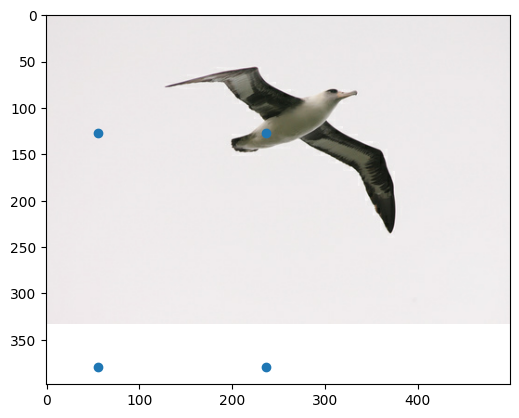

In [70]:
from matplotlib import pyplot as plt
for t in train.take(1):
  image = t['image']
  bbox = t['bbox']
  x_size = image.shape[0]
  y_size = image.shape[1]
  x0 = bbox[0] * x_size
  x1 = bbox[2] * x_size
  y0 = bbox[1] * y_size
  y1 = bbox[3] * y_size
  print(x0, x1, y0, y1)
  plt.imshow(t['image'])
  plt.scatter([x0, x0, x1, x1], [y0, y1, y1, y0])

In [64]:
print(info)

tfds.core.DatasetInfo(
    name='caltech_birds2011',
    full_name='caltech_birds2011/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_path=PosixGPath('/tmp/tmpfjmy3ln3tfds'),
    file_format=tfrecord,
    download_size=1.11 GiB,
    dataset_size=1.11 GiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'segmentation_mask': Image